
# Value at Risk (VaR) - 多情况分析演示

📌 本 notebook 用于演示如何使用 Python 进行 VaR（风险价值）计算，
以等权重的债券ETF组合为例，利用历史模拟法估算 1-day 95% 的 VaR。并对其进行多情况冲击下的模拟计算。


In [4]:
# 导入所需的库
# 我们将使用 Yahoo Finance 提供的历史数据来进行计算
# pandas 和 numpy 用于数据处理，matplotlib 用于可视化结果
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import minimize

# 忽略未来版本相关的警告，避免界面混乱
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1️⃣ 设置债券 ETF 投资组合

我们以五只**新兴市场债券相关的 ETF**为例，构建一个**等权重投资组合**，用于进行后续的 VaR 风险分析。选择它们的原因是：这些 ETF 分别代表不同类型和币种的新兴市场债券敞口，能够较全面地反映整体市场的信用风险与利率风险。

| Ticker | ETF 名称 | 简要说明 |
|--------|----------|----------|
| **EMHY** | iShares J.P. Morgan EM High Yield Bond ETF | 投资于新兴市场的**高收益（高风险）**债券 |
| **HYEM** | VanEck EM High Yield Bond ETF | 与 EMHY 类似，覆盖更广泛的新兴市场高收益债券 |
| **EMB** | iShares J.P. Morgan USD EM Bond ETF | 投资于以**美元计价**的新兴市场主权和公司债 |
| **PCY** | Invesco EM Sovereign Debt ETF | 更专注于**政府债券**，也以美元计价 |
| **EMLC** | VanEck JP Morgan EM Local Currency Bond ETF | 投资于**本币计价**的新兴市场主权债，强调货币风险敞口 |

📌 组合覆盖了高收益债券、美元主权债、本币债，能够更全面地评估市场波动下的潜在损失。


In [6]:
tickers = ['EMHY', 'HYEM', 'EMB', 'PCY', 'EMLC']

## 2️⃣ 下载历史收盘价数据

我们选择**过去三年**的日收盘价数据，作为分析基础。

📌 这里选择三年的跨度，既能覆盖多个市场波动周期，又能保持数据的可控规模。

In [8]:
raw = yf.download(tickers, start='2022-08-01', end='2025-08-01', progress=False)
prices = raw['Close']
prices.columns.name = None  # 移除列名多层索引，使 DataFrame 更清晰
prices.head(10)  #我们观测前十行的数据，确认数据的完整性

,EMB,EMHY,EMLC,HYEM,PCY
Date,,,,,
2022-08-01,75.381744,28.554590,20.263189,14.603672,15.928357
2022-08-02,74.286125,28.236591,20.021959,14.430507,15.666430
2022-08-03,75.715530,28.717669,20.229912,14.644901,16.018391
2022-08-04,75.878189,28.791050,20.354685,14.628410,16.018391
2022-08-05,75.724129,28.815504,20.221596,14.636657,16.010202
2022-08-08,76.845375,29.263968,20.362999,14.735608,16.288507
2022-08-09,75.561478,28.750280,20.321413,14.611913,16.018391
2022-08-10,76.913841,29.353659,20.662457,14.793330,16.452208
2022-08-11,76.597160,29.361813,20.670776,14.727365,16.329433


## 3️⃣ 检查缺失值并处理

In [10]:
if prices.isna().sum().sum() > 0:
    print("⚠️ 存在缺失值，进行前向填充...")
    prices = prices.fillna(method='ffill')

## 4️⃣ 计算每日对数收益率

在金融分析中，我们通常使用**对数收益率**（Log Return）来衡量价格的相对变化幅度，特别适用于多期收益的叠加场景。

对数收益率的计算公式如下：

$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

其中：
$$
  P_t ：第  t  天的价格   
   ，r_t ：第  t  天的对数收益率
$$
相比简单收益率，对数收益率在数学上更具可加性，便于时间序列分析和风险建模。


In [12]:
returns = prices.pct_change().dropna()
returns.head(10)

,EMB,EMHY,EMLC,HYEM,PCY
Date,,,,,
2022-08-02,-0.014534,-0.011137,-0.011905,-0.011858,-0.016444
2022-08-03,0.019242,0.017037,0.010386,0.014857,0.022466
2022-08-04,0.002148,0.002555,0.006168,-0.001126,0.000000
2022-08-05,-0.002030,0.000849,-0.006538,0.000564,-0.000511
2022-08-08,0.014807,0.015563,0.006993,0.006761,0.017383
2022-08-09,-0.016708,-0.017554,-0.002042,-0.008394,-0.016583
2022-08-10,0.017898,0.020987,0.016782,0.012416,0.027082
2022-08-11,-0.004117,0.000278,0.000403,-0.004459,-0.007462
2022-08-12,0.007598,0.005554,0.007646,0.010638,0.015037


## 5️⃣ 设置组合权重并计算组合收益

In [14]:
#等权重投资组合仅为示例，实际情况中可更换权重
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
portfolio_ret = returns.dot(weights)
portfolio_ret.head(10)

Date
2022-08-02   -0.013175
2022-08-03    0.016798
2022-08-04    0.001949
2022-08-05   -0.001533
2022-08-08    0.012301
2022-08-09   -0.012256
2022-08-10    0.019033
2022-08-11   -0.003072
2022-08-12    0.009295
2022-08-15   -0.002374
dtype: float64

## 6️⃣ 使用历史模拟法计算 VaR
VaR（风险价值）是一种衡量在给定置信水平下，金融资产在一定持有期内可能发生的**最大损失**的风险度量方法。

在本示例中，我们使用 **历史模拟法（Historical Simulation Method）** 来估算 1 日期的 VaR。  
该方法基于历史收益率的分布，不依赖于参数假设（如正态分布）。

VaR 的数学定义如下：

$$
\text{VaR}_{\alpha} = -\text{Quantile}_{1 - \alpha}(R)
$$

其中：
- ${\alpha}$ ：置信水平（例如 0.95 表示 95%）  
-  $R$ ：组合的历史收益率序列

📌 举例：95% VaR = -2% 表示：未来一天有 95% 的概率，损失不会超过 2%。

In [16]:
confidence = 0.95
var_95 = np.percentile(portfolio_ret, (1 - confidence) * 100)

portfolio_value = 10_000_000  # 示例：1000 万美元
dollar_var = portfolio_value * var_95

print(f"\n📉 1-day 95% VaR (历史模拟法): {var_95:.4%}")
print(f"💰 名义 VaR（对应 1000 万美元组合）: ${dollar_var:,.0f}\n")


📉 1-day 95% VaR (历史模拟法): -0.8835%
💰 名义 VaR（对应 1000 万美元组合）: $-88,349



## 7️⃣ 可视化：每日收益率分布与 VaR

在这张图中，我们将投资组合的每日收益率绘制成直方图，以直观展示大多数交易日的收益分布集中在什么范围。

- **X轴（横轴）**：每日收益率（Return）。
- **Y轴（纵轴）**：发生次数（Frequency），即有多少天出现了该区间的收益。
- 直方图的蓝色区域表示不同收益率出现的频数分布。
- 红色虚线标出了 **95%置信水平的VaR**，表示：
  > 有95%的概率，组合每日收益率不会低于这个阈值。
- 在图例中，我们也用百分比形式标明了VaR的数值（例如 -0.88%），帮助理解它所代表的潜在最大单日损失。
  
通过这张图可以更清晰地看出：
- 收益分布并不是完全对称的，存在一定偏态。
- VaR位于分布左侧的尾部，是极端不利结果的分界线。
- VaR在历史数据中的含义。


累积收益率（复利）：34.69%
最大单日收益率：3.83%


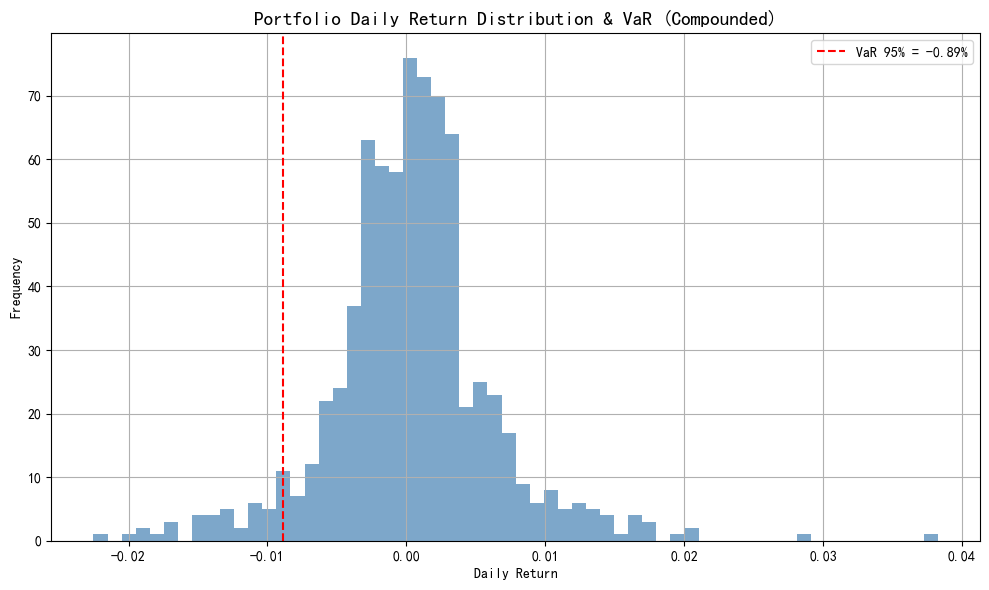

In [85]:
# 每日组合对数收益率
portfolio_log_ret = np.log(1 + portfolio_ret)

# 计算复利累计收益率
cumulative_return = np.exp(portfolio_log_ret.sum()) - 1

# 最大单日简单收益率
max_daily_return = portfolio_ret.max()

# 打印指标
print(f"累积收益率（复利）：{cumulative_return:.2%}")
print(f"最大单日收益率：{max_daily_return:.2%}")

# 绘制分布
plt.figure(figsize=(10,6))
plt.hist(portfolio_ret, bins=60, color='steelblue', alpha=0.7)
var_95 = np.percentile(portfolio_ret, 5)
plt.axvline(var_95, color='red', linestyle='--', label=f'VaR 95% = {var_95:.2%}')
plt.title('Portfolio Daily Return Distribution & VaR (Compounded)', fontsize=14)
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ✅ CVaR（Conditional Value at Risk，条件在险价值）

CVaR 是对 VaR 的补充，关注在超过 VaR 的损失情况下的**平均损失**，可以更好地刻画极端风险情景下的潜在损失。
相比 VaR 只能告诉我们“最坏的哪一天可能亏多少”，CVaR（Conditional VaR）更进一步：  
它告诉我们**在最坏的那些天里，平均会亏多少**。这更适合评估极端情况下的真实损失。

CVaR 的数学定义如下：

$$
\text{CVaR}_{\alpha} = -\mathbb{E}[R \mid R \leq \text{VaR}_{\alpha}]
$$

即：在收益 \( R \) 小于 VaR 的条件下的**期望损失**。

📌 例如：CVaR = -4% 意味着，在最坏的 5% 情况中，平均会亏损 4%。

In [20]:
# 计算组合每日收益率
returns = prices.pct_change().dropna()

# 假设等权重组合
weights = np.array([1/len(tickers)] * len(tickers))
portfolio_returns = returns @ weights

# 计算 VaR 与 CVaR
confidence_level = 0.95
var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
cvar = portfolio_returns[portfolio_returns <= var].mean()

print(f"{int(confidence_level*100)}% VaR: {var:.4f}")
print(f"{int(confidence_level*100)}% CVaR: {cvar:.4f}")

95% VaR: -0.0088
95% CVaR: -0.0123



## ✅ VaR 贡献度分析（敏感性分析）

此模块用于分析各资产对组合总体 VaR 的边际贡献和总贡献（Component VaR），并可视化展示在热力图中，便于识别高风险来源。


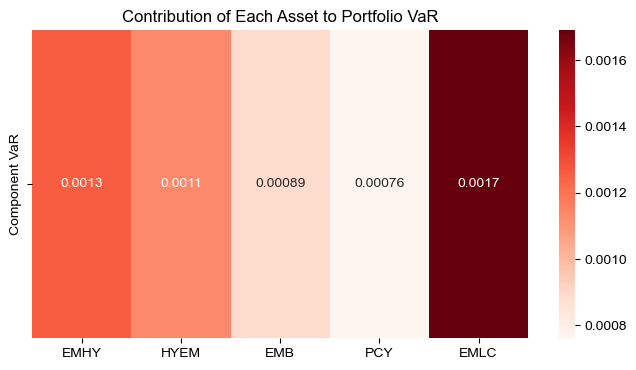

In [22]:
# 计算协方差矩阵 & 年化波动
cov_matrix = returns.cov()
portfolio_vol = np.sqrt(weights.T @ cov_matrix @ weights)

# 计算 Marginal VaR（边际 VaR）
marginal_var = cov_matrix @ weights / portfolio_vol

# 资产贡献度 (Component VaR)
component_var = weights * marginal_var

# 绘制热力图
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(8, 4))
sns.heatmap(
    component_var.values.reshape(1, -1),
    cmap="Reds",
    annot=True,
    xticklabels=tickers,
    yticklabels=["Component VaR"]
)
plt.title("Contribution of Each Asset to Portfolio VaR")
plt.show()

## ✅  Rolling VaR （60日窗口分析）

在本部分，我们希望观察 VaR 随时间的变化情况。

**为什么要做滚动分析？**
- VaR 并不是一个固定不变的数字，而是会随着市场波动而波动。当市场波动性上升时，VaR 也会升高，意味着潜在损失风险增加。

**处理方式**
- 在这里，我们将使用一个滚动窗口（这里是过去60个交易日）。
- 对每个时间点，计算过去60天收益率的5%分位数（即95%置信水平VaR）。

**图表说明：**
- 蓝色线：每日组合收益率。
- 红色线：滚动60日历史VaR（95%置信水平）。
  - 这个线越高，表示在该阶段市场风险越大。
  - 如果蓝线（实际收益）低于红线，说明当天的亏损超出了VaR预测。
  
通过这个动态视角，可以更好地理解：
- 1.VaR随市场环境如何波动。
- 2.不同阶段市场波动性的差异。


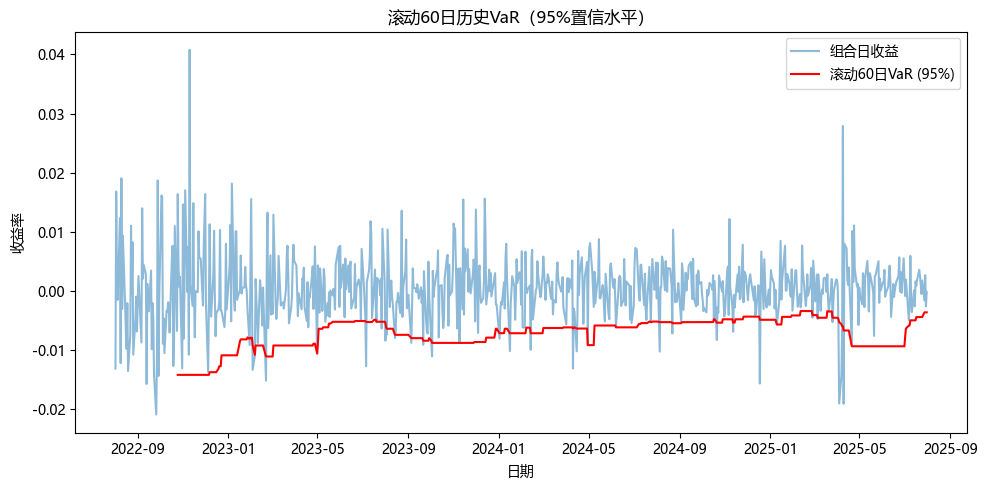

In [24]:
# --- 滚动VaR计算（历史模拟法，60日窗口）---
# 此模块展示组合风险如何随时间动态变化

import warnings
warnings.filterwarnings("ignore")  # 忽略可能的警告

import matplotlib
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
matplotlib.rcParams['axes.unicode_minus'] = False

rolling_window = 60  # 滚动窗口大小为60天
rolling_var_95 = portfolio_ret.rolling(window=rolling_window).quantile(0.05)  # 计算滚动VaR

# 绘图展示滚动VaR与实际组合收益
plt.figure(figsize=(10, 5))
plt.plot(portfolio_ret.index, portfolio_ret, label='组合日收益', alpha=0.5)
plt.plot(rolling_var_95, color='red', label=f'滚动{rolling_window}日VaR (95%)')
plt.title(f'滚动{rolling_window}日历史VaR（95%置信水平）')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.tight_layout()
plt.show()


## ✅ 压力冲击模拟


In [49]:
# 📌 基于ETF类型模拟差异化冲击，并绘制柱状图

# 将ETF分类
etf_groups = {
    "高收益债": ["EMHY", "HYEM"],
    "美元主权债": ["EMB", "PCY"],
    "本币主权债": ["EMLC"]
}

# 为每种ETF分配索引
group_indices = {group: [tickers.index(etf) for etf in names if etf in tickers]
                 for group, names in etf_groups.items()}

# 定义三种压力场景的冲击（单位为额外对数收益率冲击）
stress_scenarios = {
    "温和经济放缓": {"高收益债": -0.01, "美元主权债": -0.005, "本币主权债": -0.003},
    "金融市场恐慌": {"高收益债": -0.04, "美元主权债": -0.015, "本币主权债": -0.02},
    "新兴市场货币危机": {"高收益债": -0.03, "美元主权债": -0.01, "本币主权债": -0.05},
}

for scenario_name, shocks in stress_scenarios.items():
    # 创建一个与原始收益矩阵形状相同的冲击矩阵
    shock_matrix = np.zeros_like(returns)

    # 将每组 ETF 的冲击填入矩阵
    for group, indices in group_indices.items():
        for idx in indices:
            shock_matrix[:, idx] = shocks[group]

    # 将冲击施加在原始收益上
    shocked_returns = returns.values + shock_matrix

    # 计算组合收益
    shocked_portfolio_returns = shocked_returns @ weights

    # 计算 VaR（取 5% 分位数）
    shocked_var = np.percentile(shocked_portfolio_returns, 5)
    shocked_dollar_var = shocked_var * portfolio_value

    scenario_losses[scenario_name] = shocked_dollar_var
    print(f"{scenario_name}: VaR = {shocked_var:.2%}, 损失金额 = ${shocked_dollar_var:,.0f}")

温和经济放缓: VaR = -1.54%, 损失金额 = $-154,349
金融市场恐慌: VaR = -3.48%, 损失金额 = $-348,349
新兴市场货币危机: VaR = -3.48%, 损失金额 = $-348,349


## ✅VaR的蒙特卡洛模拟

在这一部分，我们通过**蒙特卡洛模拟（Monte Carlo Simulation）**来估算投资组合的VaR。

蒙特卡洛模拟是一种**随机抽样**的方法：

- 根据历史收益率估算出均值 $\mu$ 和标准差 $\sigma$。
- 假设未来收益率服从正态分布 $N(\mu, \sigma^2)$。
- 反复生成很多（这里是10,000次）模拟样本。
- 从模拟分布中直接取 **5%分位数**，即95%置信水平的VaR。

**数学表达：**

如果：

$$
R_i \sim N(\mu, \sigma^2), \quad i=1,...,N
$$

$$
VaR_{95\%} = \text{Percentile}_{5\%}\bigl(\{R_i\}\bigr)
$$

那么：

$$
\text{VaR金额} = VaR_{95\%} \times \text{组合市值}
$$


Monte Carlo 模拟的 1-day VaR (95%): -1.5345%
对应 1000 万美元组合的名义 VaR 是: $-153,453


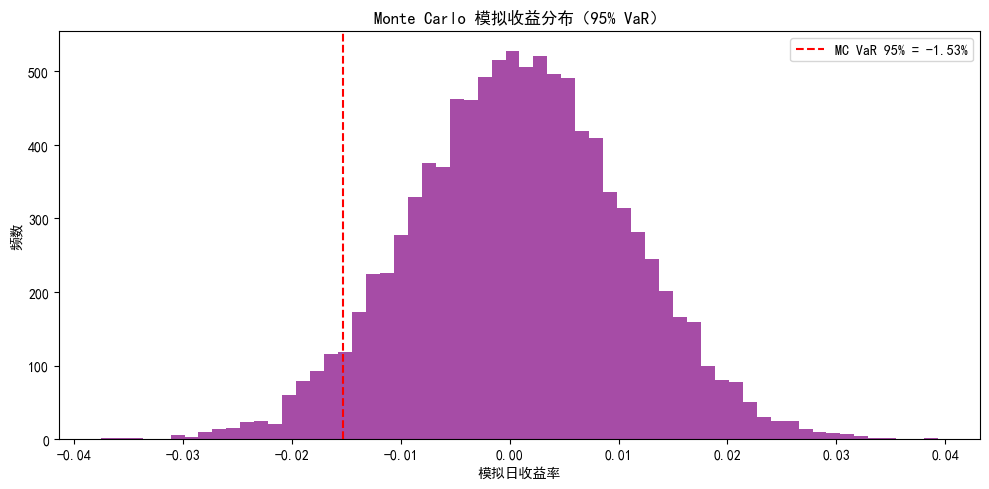

In [28]:
plt.rcParams['font.family'] = 'SimHei'  # 中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

portfolio_ret = np.random.normal(0.0005, 0.01, size=756)  # 模拟收益率序列

# 假设组合市值为1000万美元（用于换算为名义VaR）
portfolio_value = 10_000_000

# --- Monte Carlo Simulation for VaR ---
# 使用正态分布模拟未来价格路径，计算 VaR

np.random.seed(42)  # 设置随机种子，保证结果可复现
simulations = 10000  # 模拟次数

# 计算组合的平均收益率与标准差
mean_ret = portfolio_ret.mean()
std_ret = portfolio_ret.std()

# 模拟未来收益（正态分布）
simulated_returns = np.random.normal(loc=mean_ret, scale=std_ret, size=simulations)

# 获取5%分位点作为VaR
monte_carlo_var_95 = np.percentile(simulated_returns, 5)

# 换算成名义VaR金额
dollar_mc_var = portfolio_value * monte_carlo_var_95

# 打印结果
print(f"Monte Carlo 模拟的 1-day VaR (95%): {monte_carlo_var_95:.4%}")
print(f"对应 1000 万美元组合的名义 VaR 是: ${dollar_mc_var:,.0f}")

# 可视化：直方图展示模拟收益分布
plt.figure(figsize=(10, 5))
plt.hist(simulated_returns, bins=60, alpha=0.7, color='purple')
plt.axvline(monte_carlo_var_95, color='red', linestyle='--', label=f'MC VaR 95% = {monte_carlo_var_95:.2%}')
plt.title('Monte Carlo 模拟收益分布（95% VaR）')
plt.xlabel('模拟日收益率')
plt.ylabel('频数')
plt.legend()
plt.tight_layout()
plt.show()

## ✅投资组合优化：最小化VaR

在这一部分，我们通过**优化算法（数值最优化）**，自动搜索一组资产权重，使得组合VaR最小。

这种方法的核心思想：

- 首先利用历史收益率数据，估算各资产的日收益分布。
- 给定一组权重，将收益率加权组合，得到组合收益分布。
- 从组合收益分布里计算**5%分位数**（对应95%置信VaR）。
- 使用优化器（如SLSQP）不断调整权重，直到找到VaR最低的组合。

**约束条件：**
- 权重必须在0和1之间（不允许卖空）。
- 所有权重之和等于1（全部资金投入）。

**数学表述：**

设：
- $r_i(t)$：第$i$只资产在时刻$t$的收益率
- $w_i$：第$i$只资产的权重

**组合收益率：**
$$
R_{\text{portfolio}}(t) = \sum_{i=1}^N w_i \cdot r_i(t)
$$

**组合VaR（95%置信水平）：**
$$
VaR_{95\%} = - \text{Percentile}_{5\%}\left( \{ R_{\text{portfolio}}(t) \} \right)
$$

**优化目标：**
$$
\min_{w}\quad VaR_{95\%}
$$

**约束：**
$$
\sum_{i=1}^N w_i = 1
$$
$$
0 \le w_i \le 1
$$

在Python中，我们使用`scipy.optimize.minimize()`函数，给定目标函数（负的5%分位数），以及上述约束条件，求解最优权重。

最后将VaR乘以投资组合市值，得到**VaR金额**：
$$
\text{VaR金额} = VaR_{95\%} \times \text{组合市值}
$$


In [30]:
# Step 1: 计算每日收益率矩阵
asset_returns = prices.pct_change().dropna()

# Step 2: 定义资产数量
num_assets = asset_returns.shape[1]

# Step 3: 定义 VaR 函数（负号是因为要最小化负的VaR）
def portfolio_var(weights, returns, alpha=0.05):
    port_ret = returns.dot(weights)
    return -np.percentile(port_ret, alpha * 100)

# Step 4: 初始等权权重
x0 = np.ones(num_assets) / num_assets

# Step 5: 权重边界和约束
bounds = [(0, 1) for _ in range(num_assets)]
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Step 6: 组合市值（比如1000万美元）
portfolio_value = 10_000_000

# Step 7: 执行优化
opt_result = minimize(portfolio_var, x0,
                      args=(asset_returns.values,),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

# Step 8: 输出结果
if opt_result.success:
    opt_weights = opt_result.x
    opt_var_95 = -portfolio_var(opt_weights, asset_returns.values)
    opt_dollar_var = opt_var_95 * portfolio_value

    print("✅ 最小VaR组合权重：")
    for name, w in zip(prices.columns, opt_weights):
        print(f"   {name}: {w:.3f}")

    print(f"\n组合 VaR (95%) 最小值：{opt_var_95:.4%}")
    print(f"对应 1000 万美元组合的名义 VaR：${opt_dollar_var:,.0f}")
else:
    print("❌ 优化失败：", opt_result.message)


✅ 最小VaR组合权重：
   EMB: 0.068
   EMHY: 0.074
   EMLC: 0.562
   HYEM: 0.296
   PCY: 0.000

组合 VaR (95%) 最小值：-0.6882%
对应 1000 万美元组合的名义 VaR：$-68,816
